# Finance Analytics

## Overview

**Business Question:**
“How have major U.S. tech stocks performed and co-moved over the past five years, and what can this tell us about risk, return, and diversification in the sector?”

**Data:** 
Stock price and volume data encapsulate investor sentiment, funamentals, and macro factors. Using daily adjusted close prices allows return-based comparison across companies and over time.

## Data Collection & Description
Data will be collected via the yahoo finance library. This data is accurate, up to date, and with no missing values. To evaluate performance, we will be pulling the daily high, low, open, close, and volume of each stock as our core metrics and diving deeper.

### Setup

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

print('Setup Complete')

Setup Complete


### Data Collection & Description

Pull data from all tickers into one table with columns `date, close, high, low, open, volume, ticker`. This formatting gives us all the raw data and allows for easier aggregation of metrics in the future. The time window we are interested in looking at is the last 3 years of stock prices. This is a time frame that captures a majority of cycles/patterns and gives us a balance of metrics we can look at without being too wide or narrow.

In [12]:
tickers = ['NVDA', 'PLTR', 'GOOGL'] # Nvidia, Palantir, Google
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)

all_data = []
for ticker in tickers:
    table = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    
    table = table.reset_index()
    
    table.columns = ['date', 'close', 'high', 'low', 'open', 'volume']
    table['ticker'] = ticker
    
    all_data.append(table)

df = pd.concat(all_data, ignore_index=True)
df = df.sort_values(['ticker', 'date'])
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,date,close,high,low,open,volume,ticker
1504,2022-10-31,93.862625,95.372210,93.336257,94.766388,31675000,GOOGL
1505,2022-11-01,89.850296,95.372208,89.750983,94.796180,47161400,GOOGL
1506,2022-11-02,86.374260,90.555421,86.284873,90.317067,57038300,GOOGL
1507,2022-11-03,82.858521,85.927351,82.769133,85.728724,61288000,GOOGL
1508,2022-11-04,85.986946,86.046533,83.136602,84.815029,51124900,GOOGL
...,...,...,...,...,...,...,...
1499,2025-10-23,180.479996,181.559998,175.009995,175.445007,35812300,PLTR
1500,2025-10-24,184.630005,186.169998,182.850006,182.880005,34813500,PLTR
1501,2025-10-27,189.179993,192.830002,187.520004,188.970001,47153100,PLTR
1502,2025-10-28,189.600006,191.779999,186.779999,189.479996,38201000,PLTR


Great, we were able to ingest our data without any errors, and it looks like it's in the format that we want. We want to make sure our data is clean and tidy, ensuring no duplicates, nulls, or other kinds of invalid values. Let's do some sanity checks like seeing if there are any rows with an incorrect high or low, or if any price is nonpositive.

In [13]:
print(df.info())
print('------------------------------------------------------------------------------')
print(f"Number of duplicate rows: {df.duplicated(subset=['date', 'ticker']).sum()}")
print('------------------------------------------------------------------------------')
print('Number of Nulls')
print (df.isnull().sum())
print('------------------------------------------------------------------------------')
# High must be >= Open, Close, and Low
invalid_high = df[df['high'] < df[['open', 'close', 'low']].max(axis=1)]

# Low must be <= Open, Close, and High
invalid_low = df[df['low'] > df[['open', 'close', 'high']].min(axis=1)]

print(f"Rows with impossible 'High' prices: {len(invalid_high)}")
print(f"Rows with impossible 'Low' prices: {len(invalid_low)}")

# Check if any price is non-positive
non_positive_prices = df[
    (df['open'] <= 0) | (df['high'] <= 0) | 
    (df['low'] <= 0) | (df['close'] <= 0)
]
# Check if volume is negative (zero is checked in step 4)
negative_volume = df[df['volume'] < 0]

print(f"Rows with non-positive prices: {len(non_positive_prices)}")
print(f"Rows with negative volume: {len(negative_volume)}")

<class 'pandas.core.frame.DataFrame'>
Index: 2256 entries, 1504 to 1503
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2256 non-null   datetime64[ns]
 1   close   2256 non-null   float64       
 2   high    2256 non-null   float64       
 3   low     2256 non-null   float64       
 4   open    2256 non-null   float64       
 5   volume  2256 non-null   int64         
 6   ticker  2256 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 141.0+ KB
None
------------------------------------------------------------------------------
Number of duplicate rows: 0
------------------------------------------------------------------------------
Number of Nulls
date      0
close     0
high      0
low       0
open      0
volume    0
ticker    0
dtype: int64
------------------------------------------------------------------------------
Rows with impossible 'High' prices

Everything looks good, we're good to continue. We'll be paying most attention to Close (adjusted) price and volume to evaluate our metrics. Let's see what we're looking at so far

Close Price Statistics by Ticker
              mean        std        min         max
ticker                                              
GOOGL   151.834769  38.834453  82.858521  274.570007
NVDA     89.703926  52.712487  13.203137  207.039993
PLTR     51.565279  53.470860   6.000000  198.809998


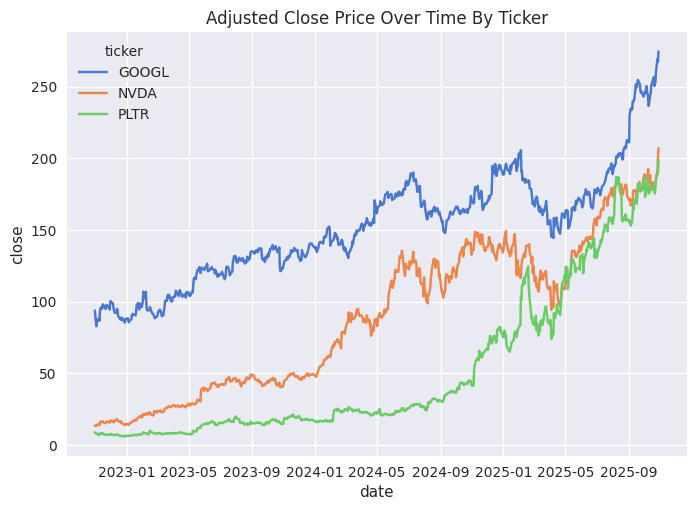

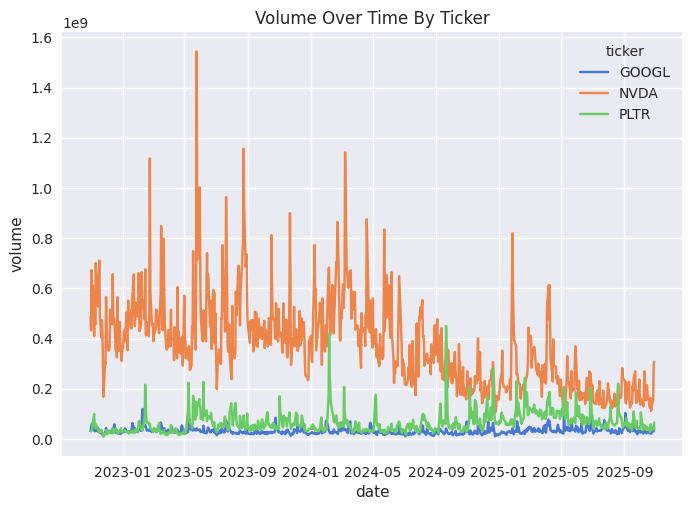

In [14]:
print('Close Price Statistics by Ticker')
print(df.groupby('ticker')['close'].describe()[['mean', 'std', 'min', 'max']])
sns.lineplot(df, x='date', y='close', hue='ticker')
plt.title('Adjusted Close Price Over Time By Ticker')
plt.show()
sns.lineplot(df, x='date', y='volume', hue='ticker')
plt.title('Volume Over Time By Ticker')
plt.show()

Just by looking at these simple figures, we can draw the following insights:
- NVDA and PLTR seem to show much higher growth and volatility (fluctuation) than GOOGL
- NVDA seems to skyrocket beginning mid-2023 which could be linked to the AI boom and consequent GPU demand
- PLTR's price sharply climbed in 2024-2025
- GOOGL shows steadier, more moderate growth with periodic dips and recoveries.
- All three show a strong upward trend in 2024-2025
- NVDA has vastly higher trading volume, peaking above 1 billion shares showing strong liquidity and investor attention
- GOOGL has relatively stable, low trading volume

## EDA

### Measuring Growth & Performance
To determine how well these stocks are doing, we'll be looking at the following metrics:
- Daily Returns: The % change in close price day to day. This measures the % of your equity that you would gain/lose for the day
- Cumulative Returns: tracks how much an investment has grown over time relative to the starting point. If cumulative return = 5, then the stock has grown 5x its value at the initial time period.

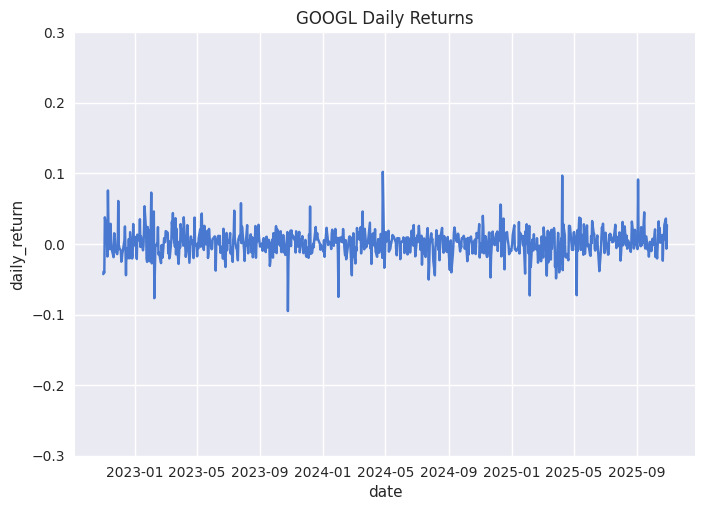

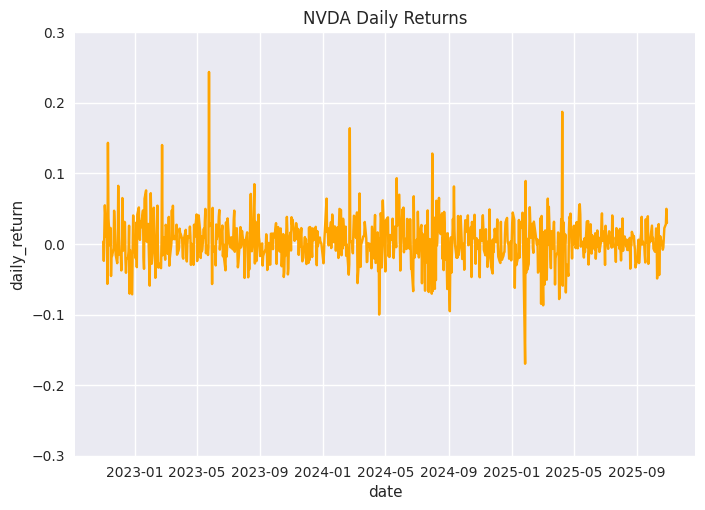

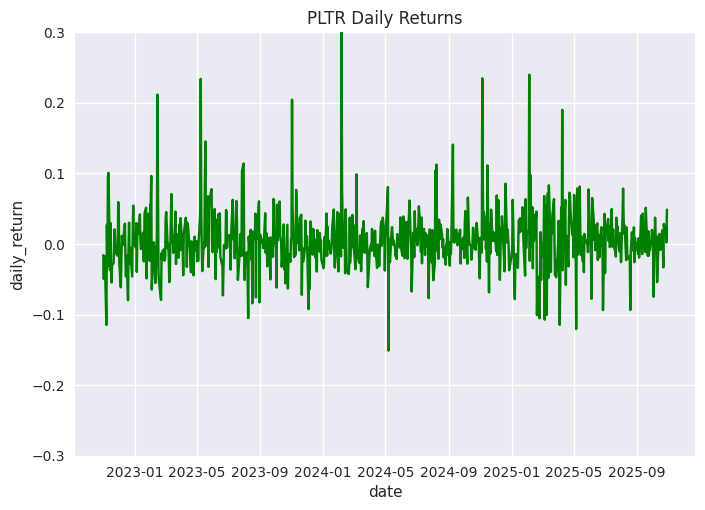

Average Daily Returns by Ticker
ticker
GOOGL    0.001618
NVDA     0.004164
PLTR     0.005035
Name: daily_return, dtype: float64


In [15]:
df["daily_return"] = df.groupby('ticker')['close'].pct_change()
df_googl = df[df['ticker'] == 'GOOGL']
df_nvda = df[df['ticker'] == 'NVDA']
df_pltr = df[df['ticker'] == 'PLTR']
avg_returns = df.groupby('ticker')['daily_return'].mean()

sns.lineplot(data=df_googl, x='date', y='daily_return',)
plt.title('GOOGL Daily Returns')
plt.ylim(-.3, .3)
plt.show()
sns.lineplot(data=df_nvda, x='date', y='daily_return', color='orange')
plt.title('NVDA Daily Returns')
plt.ylim(-.3, .3)
plt.show()
sns.lineplot(data=df_pltr, x='date', y='daily_return', color='green')
plt.title('PLTR Daily Returns')
plt.ylim(-.3, .3)
plt.show()

print('Average Daily Returns by Ticker')
print(avg_returns)

To no surprise, PLTR leads with the highest average return, with NVDA and GOOGL following in that order. However, telling by these visuals, PLTR seems to vary the most, while GOOGL seems to be the most stable of the 3. Let's take on another perspective by looking at cumulative returns to see how much these equities have compounded the last 5 years.

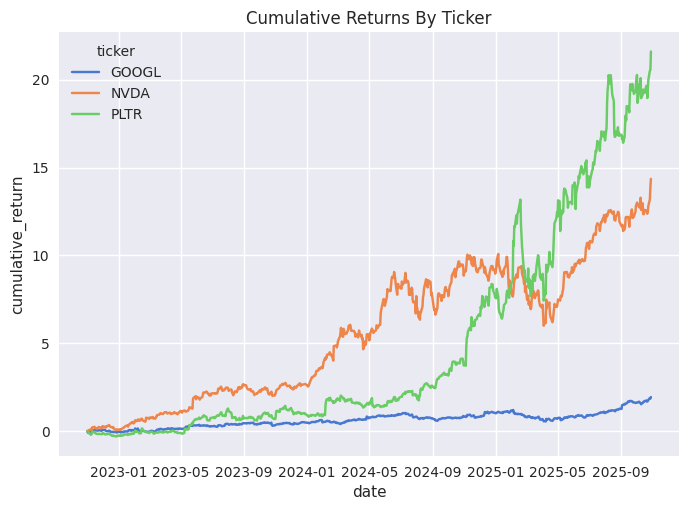

Cumulative Returns at End Date
  ticker  final_cumulative_return
0  GOOGL                 1.925233
1   NVDA                14.358136
2   PLTR                21.617747


In [16]:
df["cumulative_return"] = (1 + df["daily_return"]).groupby(df["ticker"]).cumprod() - 1
sns.lineplot(data=df, x='date', y='cumulative_return', hue='ticker')
plt.title('Cumulative Returns By Ticker')
plt.show()
print('Cumulative Returns at End Date')
final_cum_returns = (
    df.groupby("ticker")["cumulative_return"]
      .last()
      .reset_index()
      .rename(columns={"cumulative_return": "final_cumulative_return"})
)
print(final_cum_returns)

Here are some of the insights we can draw from looking at these cumulative returns:
- In 3 Years, the value of GOOGL stock has grown 1.92x, NVDA 14.4x, and PLTR 21.6X
- We see the same trend, where GOOGL grows slowly and steadily, while PLTR and NVDA have experienced rapid growth especially in the past 2-3 years, likely as a result of AI and analytics surges.
- NVDA and PLTR appear to swing a lot more with sharp peaks and dips, indicating volatility. 
- We see similar movement across the 3, indicating tech sector correlation

However, there are a lot of other factors to consider, and these 2 metrics alone don't inform enough about the potential opportunity in investing in these stocks. We're encountering the concept of risk/volatility which is the uncertainty of reward and potential for loss. In our next step, we will quantify risk to give a better overall evaluation of performance.

### Volatility

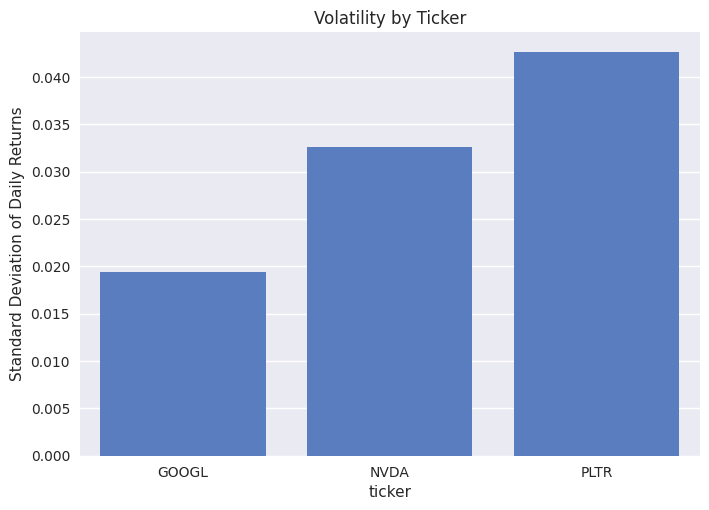

In [ ]:
# Standard deviation of daily returns as a measure of volatility
volatility = df.groupby("ticker")["daily_return"].std()
sns.barplot(x=volatility.index, y=volatility.values)
plt.title("Volatility by Ticker")
plt.ylabel("Standard Deviation of Daily Returns")

plt.show()

This tells us that on average in the last 3 years, GOOGL's returns fluctuate by around 2% every day, while NVDA fluctuates by 3.5% and PLTR by 4.5%. This tells us that GOOGL reflects a mature, large-cap company with stable cash flows and broader investor confidence, whereas PLTR reacts strongly to earnings, hype, and sentiment shifts.

However, Volatility can fluctuate over time so this doesn't give us a very accurate depiction of the spread of returns. So, to understand how "risky" these stocks have been and where they are right now, we want to calculate rolling volatilities over windows of 30 days, 90 days, etc.. The diffwerent windows inform risks for different kinds of trading strategies.

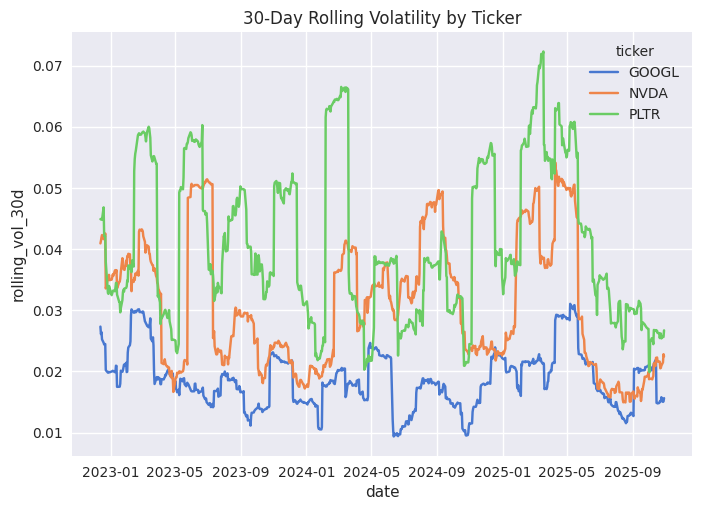

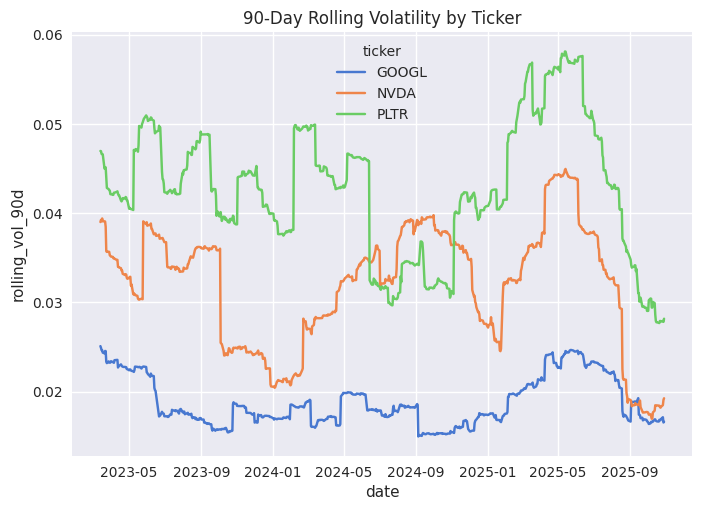

In [20]:
df['rolling_vol_30d'] = df.groupby('ticker')['daily_return'].rolling(window=30).std().reset_index(0, drop=True)
df['rolling_vol_90d'] = df.groupby('ticker')['daily_return'].rolling(window=90).std().reset_index(0, drop=True)
sns.lineplot(data=df, x='date', y='rolling_vol_30d', hue='ticker')
plt.title('30-Day Rolling Volatility by Ticker')
plt.show()
sns.lineplot(data=df, x='date', y='rolling_vol_90d', hue='ticker')
plt.title('90-Day Rolling Volatility by Ticker')
plt.show()

Volatility isn't always a bad thing, sometimes the higher the risk, the higher reward. We want to see if these equities are worth the risk, their Sharpe Ratio in other words (the ratio of average daily return to volatility)

In [18]:
sharpe_ratio = avg_returns / volatility * np.sqrt(252)  # Annualized Sharpe Ratio
print('Annualized Sharpe Ratios by Ticker')
print(sharpe_ratio)

Annualized Sharpe Ratios by Ticker
ticker
GOOGL    1.321936
NVDA     2.030349
PLTR     1.876163
Name: daily_return, dtype: float64


In [19]:
df["rolling_volatility_30d"] = (
    df.groupby("ticker")["daily_return"]
      .rolling(window=30)
      .std()
      .reset_index(level=0, drop=True)
)

df["ma_50"] = (
    df.groupby("ticker")["close"]
      .rolling(window=50)
      .mean()
      .reset_index(level=0, drop=True)
)

df["ma_200"] = (
    df.groupby("ticker")["close"]
      .rolling(window=200)
      .mean()
      .reset_index(level=0, drop=True)
)

summary = (
    df.groupby("ticker")
      .agg(
          avg_daily_return = ("daily_return", "mean"),
          volatility = ("daily_return", "std"),
          cumulative_return = ("cumulative_return", "last"),
          sharpe_ratio = ("daily_return", lambda x: np.mean(x) / np.std(x)),
          max_drawdown = ("cumulative_return", lambda x: (x.cummax() - x).max())
      )
      .reset_index()
)
print(df.tail())
print('------------------------------------------------------------------------------------------')
print(summary)

           date       close        high         low        open    volume  \
1499 2025-10-23  180.479996  181.559998  175.009995  175.445007  35812300   
1500 2025-10-24  184.630005  186.169998  182.850006  182.880005  34813500   
1501 2025-10-27  189.179993  192.830002  187.520004  188.970001  47153100   
1502 2025-10-28  189.600006  191.779999  186.779999  189.479996  38201000   
1503 2025-10-29  198.809998  199.850006  190.490005  191.080002  65301300   

     ticker  daily_return  cumulative_return  rolling_volatility_30d  \
1499   PLTR      0.028435          19.532423                0.026190   
1500   PLTR      0.022994          20.004551                0.025390   
1501   PLTR      0.024644          20.522184                0.025686   
1502   PLTR      0.002220          20.569967                0.025629   
1503   PLTR      0.048576          21.617747                0.026711   

         ma_50     ma_200  
1499  171.6888  128.72525  
1500  171.7610  129.29845  
1501  172.0012  129.